# Moment-Curvature Analysis using Fiber Mesh
### Zero-length Element in OpenSeesPy
In this example the axial and flexural behavior are coupled, a characteristic of the fiber section.<br>
The nonlinear/inelastic behavior of a fiber section is defined by the stress-strain response of the uniaxial materials used to define it.<br>
This is a 3D model (to capture the local z coordinate in the section, but only 3 dofs (axial, shear, rot).

https://portwooddigital.com/2021/07/25/how-to-record-fiber-response/

```{image}Fiber_coordinates.png
:alt: Fiber_coordinates
:class: bg-primary mb-1
:width: 600px
:align: center
```


---
title: Working with MyST Markdown
subtitle: In JupyterLab
license: CC-BY-4.0
---

### Function for finding the Idealized Plastic Moment

In [1]:
def MC_Idealized(n_u, n_1y, dK, K, moment):

    n_points = K.size
    flag = 0
    i = n_u - 2           # to consider 2nd from last

    while flag == 0 and i >= n_1y:         # changes Mp to match Areas
        A_above = 0
        A_below = 0
        Mp = moment[i]

        # numerical integration under the curve difference:
        for j in range(n_u - 2, n_1y, -1):
            DA = 1/2 * ( moment[j+1] + moment[j] ) * ( K[j+1] - K[j] )
            DAp = Mp * (K[j+1] - K[j])
            if moment[j] > Mp:
                A_above = round(A_above + DA - DAp, 4)
            else:
                A_below = round(A_below + DAp - DA, 4)

        ra = round(min(abs(A_above), abs(A_below)) /  max(abs(A_above), abs(A_below)),2)
        if ra > 0.90:
            flag = 1
        else:
            i = i - 1

    return (A_above, A_below, ra, Mp)

## Main Program

###  Input Data

In [2]:
# ***********************************************************************

# OpenSees -- Open System for Earthquake Engineering Simulation
# Pacific Earthquake Engineering Research Center
# http://opensees.berkeley.edu/
#
# Moment-Curvature Example 2.1
# ----------------------------
#  Zero length Section element with fiber section
#  Single Nodal Load, Static Analysis
# 
# Example Objectives
# ------------------
# Moment-Curvature Analysis in OpenSees
# Units: kips, in, sec
#
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
    
from openseespy.opensees import *
import opsvis as opsv

#     %matplotlib ipympl
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import math
import pandas as pd

import EngPlots_MC
import EngPlots_StressStrain
import EngPlots_StrainProfile
import EngPlots_MCcomp
import EngReports
import EngDetailedReports

# remove existing model
wipe()
plt.close('all')

# create ModelBuilder (with two-dimensions and 3 DOF/node)
# ndm -> 1, 2, 3; ndf (optional)
# Use ndm = 3 for 3D model and to see z coordinate in output
model("BasicBuilder", "-ndm",3, "-ndf", 3)

# set default units
defaultUnits("-force", "kip", "-length", "in", "-time", "sec", "-temp", "F")

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["figure.figsize"] = (10, 5)

# Set axial load -ve is compression

#axialLoad = -600      # Min Axial Load for Transv Analysis
#axialLoad = -2600   # Max Axial Load for Transv Analysis
axialLoad = -1600   # Axial Load for Longitduinal Analysis

mu  = 10.0;         # Target ROT. ductility for analysis
num_steps = 100;    # Number of analysis steps (increments)

# Column Properties:
D_col = 60.0

cover = 2.0         # to hoops outside
Reb_cover = 3.58    # to cl longit. reinf.
As = 1.56           # area of no. 11 bars
n_bars = 22

r_col = D_col / 2
r_core = D_col / 2 - cover
r_reinf = D_col / 2 - Reb_cover
r_core_int = r_core - 6
r_center = 0

n_wedges = 176
n_rings_int = 6        # number of rings in the interior core
n_rings = 12           # number of rings in the core around reinf
n_rings_cover = 6

esp    = -0.004       # spalling
ecu_UL = -0.0152      # ultimate concrete strain

ecu_LL  = -0.004
est_LL  =  0.010

#esc_UL = -0.038        # bar buckling strain limit for UL Transv Min
#esc_UL = -0.019       # bar buckling strain limit for UL Transv Max
esc_UL = -0.0286      # bar buckling strain limit for UL LONGIT

#est_UL = 0.0305        # tensile strain limit for UL Transv Min
#est_UL = 0.0152       # tensile strain limit for UL Transv Max
est_UL  = 0.0229      # tensile strain limit for UL LONGIT



### Strain Limits

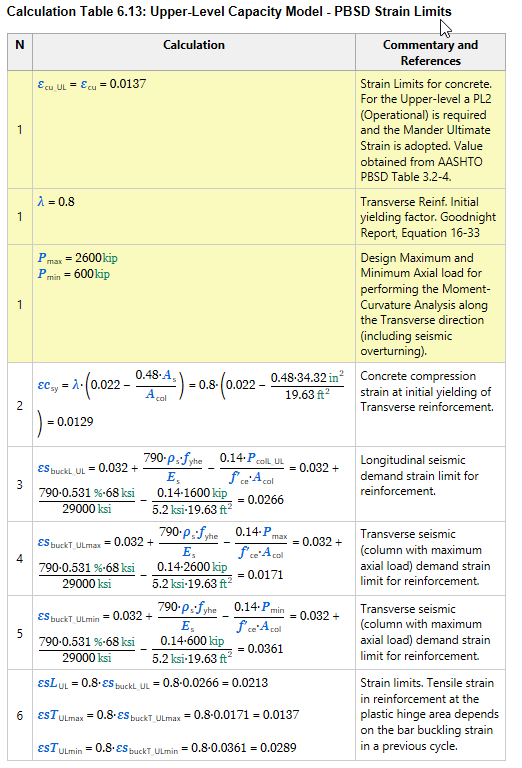

### Concrete Materials

In [3]:
# Define materials for nonlinear columns
# ------------------------------------------
fpcc = -6.27
ecpeak = -0.0045


# Unconfined
fpc = -5.2
eco = -0.002

Econc = 4347

# -------------------------------------------------------------------------
# Core concrete (confined)
uniaxialMaterial("Concrete04", 1, fpcc, ecpeak, ecu_UL, Econc, 0.0, 0.0, 0.1)
# Cover concrete (unconfined)
#uniaxialMaterial("Concrete04", 2, fpc, eco, esp, Econc, 0.0, 0.0, 0.1)
uniaxialMaterial("Concrete01", 2, fpc,eco, 0., esp)

### Reinforcement Material

In [4]:
# Reinforcing steel
# https://openseespydoc.readthedocs.io/en/latest/src/steel4.html
# https://opensees.berkeley.edu/wiki/index.php?title=Steel4_Material
# -------------------------------------------------------------------------
fye    = 68.0      # Yield stress
fue    = 95.0
Es     = 29000.0    # Young's modulus

Esh = 1500
esh = 0.0115
e_suR = 0.06
esy = fye/Es

uniaxialMaterial("ReinforcingSteel", 3, fye, fue, Es, Esh, esh, e_suR)

### Cross Section definition

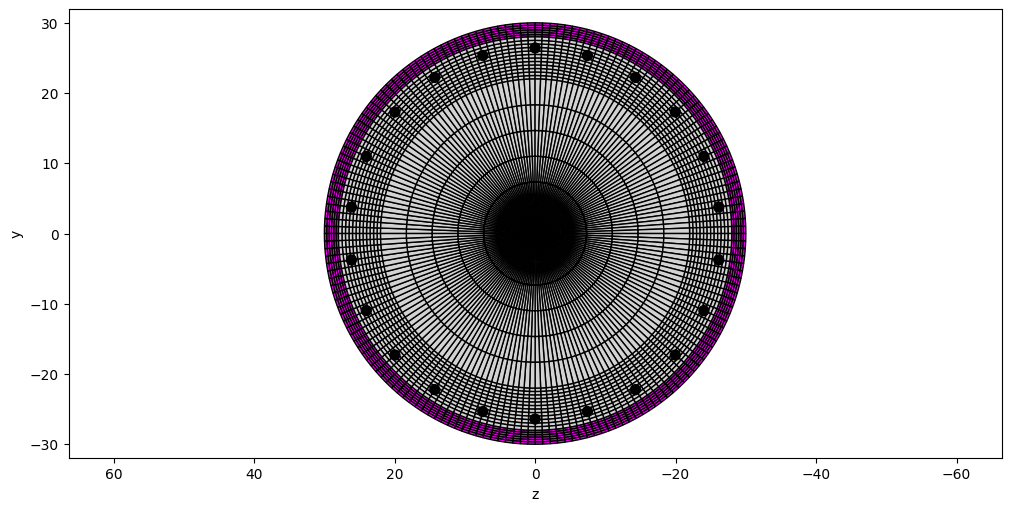

In [5]:
# Define cross-section for nonlinear columns
# https://opensees.berkeley.edu/community/viewtopic.php?p=78841&hilit=overlap#p78841
# ------------------------------------------
secTag = 1

# Do NOT overlap fibers, reinforcement fiber is overlapping concrete fiber.
# ------------------------------------------------------------------------
# n_bars defines the number of reinforcement around the perimeter and the
# number of radial concrete fibers (wedges)
# patch('circ', matTag, numWedges, numRings, *center, *rad, *ang)
# *center: y & z-coordinates of the center of the circle.
# *rad: internal and external radius

delta_conc = 360/n_wedges
delta_rebar = 360/n_bars

section("Fiber", secTag, '-GJ', 1.0e6)
patch("circ", 2, n_wedges, n_rings_cover, 0, 0, r_core, D_col/2, 0, 360)      # cover
patch("circ", 1, n_wedges, n_rings, 0, 0, r_core_int, r_core, 0, 360)         # core
patch("circ", 1, n_wedges, n_rings_int, 0, 0, r_center, r_core_int, 0, 360)   # core_int
layer("circ", 3, n_bars, As, 0, 0, r_reinf, 360/n_bars, 360)                  # reinf

# For figure only:
# -----------------
Fib_sec = [["section", "Fiber"],
           ["patch", "circ", 2, n_wedges, n_rings_cover, 0, 0, r_core, D_col/2, 0, 360],      # cover
           ["patch", "circ", 1, n_wedges, n_rings, 0, 0, r_core_int, r_core, 0, 360],         # core 
           ["patch", "circ", 1, n_wedges, n_rings_int, 0, 0, r_center, r_core_int, 0, 360],   # core_int           
           ["layer", "circ", 3, n_bars, As, 0, 0, r_reinf, 360/n_bars, 360],                  # reinf          
          ]

#opsv.fib_sec_list_to_cmds(Fib_sec)
matcolor = ['lightgrey', 'magenta', 'gold', 'w', 'w', 'w']
opsv.plot_fiber_section(Fib_sec, matcolor=matcolor)
plt.axis('equal')
plt.savefig('fibsec_rc.png')
plt.show()

### Structural Model Definition

In [6]:
# Estimate yield curvature

Ky = 2.25*esy/D_col               # AASHTO PBSD Eq. 6.2.2-6a
maxK = Ky * mu

# Print estimate to standard output:
print("Estimated yield curvature: ", round(Ky * 1000* 12, 2))

# Define two nodes at (0,0)
node(1, 0.0, 0.0, 0.0)
node(2, 0.0, 0.0, 0.0)

# FIX all degrees of freedom except NODE 2 axial and bending dof
# 0 -> Free; 1-> fixed
#   N  x  y  z  x  y  z 
fix(1, 1, 1, 1, 1, 1, 1)
fix(2, 0, 1, 0, 0, 1, 1)

# Define element
# https://openseespydoc.readthedocs.io/en/latest/src/zeroLengthSection.html
#                                   ndI ndJ secTag
eleTag = 1
element("zeroLengthSection", eleTag, 1, 2, secTag)

# Create recorder
recorder("Node", "-file", "section"+str(secTag)+".out", "-time", 
         "-node", 2, "-dof", 3, "disp")

Estimated yield curvature:  1.06


0

### Fiber Section Check

In [7]:
# section output: using fiberdata option:
# https://portwooddigital.com/2022/05/15/plane-sections-do-remain-plane/
data = eleResponse(eleTag,'section',secTag,'fiberData')
Ndata = len(data)
Nfibers = int(Ndata/5)
print("Nfibers = ", Nfibers)

y =[]
z =[]

# Python indices indicate to grab every fifth list entry: y, z, A, stress, strain
y = data[0:Ndata:5]
z = data[1:Ndata:5]
Afiber = data[2:Ndata:5]

As_reinf = 0
A_col = 0
n_rebar = 0
I_col = 0

for i in range(0, Nfibers, 1):
    if Afiber[i] == As:
        As_reinf = As_reinf + As
        n_rebar = n_rebar + 1
    else:
        A_col = A_col + Afiber[i]
        I_col = I_col + Afiber[i] * y[i] **2
        

print("n_rebar =", n_rebar)
print("A_reinf =", round(As_reinf,1), "in2")
print("A_col = ", round(A_col, 1), " in2")
print("I_col = ", round(I_col, 1), " in4")

Matrix = {'z (in)': np.round(z,2),
          'y (in)': np.round(y, 2),
          'Afiber (in2)': np.round(Afiber, 2)}

df10 = pd.DataFrame(Matrix, columns = ['z (in)', 'y (in)', 'Afiber (in2)'] )
pd.set_option('display.max_rows', None)     # Set to None to display all rows
pd.set_option('display.max_columns', None)  # Set to None to display all columns

display(df10)

Nfibers =  4246
n_rebar = 22
A_reinf = 34.3 in2
A_col =  2827.4  in2
I_col =  635256.6  in4


,z (in),y (in),Afiber (in2)
0,0.50,28.16,0.34
1,1.51,28.13,0.34
2,2.51,28.05,0.34
3,3.51,27.95,0.34
4,4.51,27.80,0.34
5,5.49,27.62,0.34
6,6.48,27.41,0.34
7,7.45,27.16,0.34
8,8.42,26.88,0.34
9,9.37,26.56,0.34


### Gravity Analysis

In [8]:
# Define constant axial load
#             type   Ts_tag
#       type, Patt_tag, Ts_tag
# nodal load, node, dofs
ts_tag = 1
load_patt = 1

timeSeries("Constant", ts_tag)
pattern("Plain", load_patt, ts_tag)    # assoc. with the time series
load(2, axialLoad, 0.0, 0.0)

# Define analysis parameters
system("BandGeneral")
constraints("Plain")
system("UmfPack")
numberer("Plain")
constraints("Transformation")

#                      tol
test("NormUnbalance", 1.0E-9, 10)
algorithm("Newton")
integrator("LoadControl", 0.0)
analysis("Static")

r_axial = axialLoad/(fpc * A_col)
print("Axial Load Ratio = ", round(r_axial,2))

# Do one analysis for constant axial load
analyze(1)


Axial Load Ratio =  0.11


0

### Structural Analysis
In this analysis an rotation is induced at the second node (which it has been constrained for rotations).<br>In a zero-length element, curvatures and rotations are equal.


In [9]:
# Define Unitary moment
# Time series is LINEAR
ts_tag = 2
load_patt = 2
timeSeries("Linear", ts_tag)
pattern("Plain", load_patt, ts_tag)
load(2, 0.0, 0.0, 1.0)

# Compute curvature increment
dK = maxK / num_steps

# Use displacement control at node 2 for section analysis
# for displacement control:    node,dof,1st_incr,#Iter,minIncr,MaxIncr
integrator("DisplacementControl", 2, 3, dK, 1, dK, dK)

K        = np.arange(0, maxK, dK)         # curvature vector
moment   = np.zeros(num_steps)
c        = np.zeros(num_steps)
EIsecant = np.zeros(num_steps)

# Python arrays: 1 x 2 vector for receiving OpenSees results
sStrainCc = np.zeros((1,2))
sStrainCt = np.zeros((1,2))
sStrainUc = np.zeros((1,2))
sStrainUt = np.zeros((1,2))
sStrainRc = np.zeros((1,2))
sStrainRt = np.zeros((1,2))

# Python arrays: Individual strain and stress vectors:
StrainConfc = np.zeros(num_steps)
StrainConft = np.zeros(num_steps)   
StrainUncfc = np.zeros(num_steps)
StrainUncft = np.zeros(num_steps)   
StrainRebc  = np.zeros(num_steps)
StrainRebt  = np.zeros(num_steps)

Straincc    = np.zeros(num_steps)
Strain_int    = np.zeros(num_steps)

StressConfc = np.zeros(num_steps)
StressConft = np.zeros(num_steps)    
StressUncfc = np.zeros(num_steps)
StressUncft = np.zeros(num_steps)    
StressRebc  = np.zeros(num_steps)
StressRebt  = np.zeros(num_steps)

# Initialization of Strain Limit variables:
K1y = 0
M1y =0
n_1y = 0

Kcu_UL = 0
Mcu_UL = 0

Ksp = 0
Msp = 0

K_Rebc_UL = 0
M_Rebc_UL = 0

K_Rebt_UL = 0
M_Rebt_UL = 0

Kcu_LL = 0
Mcu_LL = 0

K_Rebt_LL = 0
M_Rebt_LL = 0

### Axial Load Only

In [10]:
# Axial Load results, M = 0
# ----------------------------------

K[0] = 0
moment[0] = 0

# Stress-Strain two-column row vector:
sStrainCc = (eleResponse(1, 'section', 'fiber', r_core, 0,  1, 'stressStrain'))
sStrainCt = (eleResponse(1, 'section', 'fiber', -r_core, 0, 1, 'stressStrain'))
sStrainUc = (eleResponse(1, 'section', 'fiber',  r_col,  0, 2, 'stressStrain'))
sStrainUt = (eleResponse(1, 'section', 'fiber', -r_col,  0, 2, 'stressStrain'))
sStrainRc = (eleResponse(1, 'section', 'fiber',  r_reinf, 0, 3, 'stressStrain'))
sStrainRt = (eleResponse(1, 'section', 'fiber', -r_reinf, 0, 3, 'stressStrain'))

StrainConfc[0] = sStrainCc[1]
StrainConft[0] = sStrainCt[1]
StrainUncfc[0] = sStrainUc[1]
StrainUncft[0] = sStrainUt[1]
StrainRebc[0]  = sStrainRc[1]
StrainRebt[0]  = sStrainRt[1]

StressConfc[0] = sStrainCc[0]
StressConft[0] = sStrainCt[0]
StressUncfc[0] = sStrainUc[0]
StressUncft[0] = sStrainUt[0]
StressRebc[0]  = sStrainRc[0] 
StressRebt[0]  = sStrainRt[0]

### Moment - Curvature Analysis

In [11]:

i = 1
while K[i] <= maxK and i < num_steps - 1:
    Ok = analyze(1)
    moment[i] = -round(eleForce(1, 3)/12,0)
 
    # Stress-Strain two-column row vector: y and z coordinates
    sStrainCc = (eleResponse(1, 'section', 'fiber', r_core, 0,  1, 'stressStrain'))
    sStrainCt = (eleResponse(1, 'section', 'fiber', -r_core, 0, 1, 'stressStrain'))
    sStrainUc = (eleResponse(1, 'section', 'fiber',  r_col,  0, 2, 'stressStrain'))
    sStrainUt = (eleResponse(1, 'section', 'fiber', -r_col,  0, 2, 'stressStrain'))
    sStrainRc = (eleResponse(1, 'section', 'fiber',  r_reinf, 0, 3, 'stressStrain'))
    sStrainRt = (eleResponse(1, 'section', 'fiber', -r_reinf, 0, 3, 'stressStrain'))
    
    sStraincc = (eleResponse(1, 'section', 'fiber',  0, 0, 1, 'stressStrain'))
    sStrain_int = (eleResponse(1, 'section', 'fiber',  -r_core_int, 0, 1, 'stressStrain'))

    StrainConfc[i] = sStrainCc[1]
    StrainConft[i] = sStrainCt[1]
    StrainUncfc[i] = sStrainUc[1]
    StrainUncft[i] = sStrainUt[1]
    StrainRebc[i]  = sStrainRc[1]
    StrainRebt[i]  = sStrainRt[1] 
    
    Straincc[i]  = sStraincc[1]
    Strain_int[i] = sStrain_int[1]

    StressConfc[i] = sStrainCc[0]
    StressConft[i] = sStrainCt[0]
    StressUncfc[i] = sStrainUc[0]
    StressUncft[i] = sStrainUt[0]
    StressRebc[i]  = sStrainRc[0] 
    StressRebt[i]  = sStrainRt[0]

    if abs(K[i]) > 0:
        EIsecant[i] = moment[i] / (K[i] * 12)
        c[i] = round(abs(StrainUncfc[i]) / abs(K[i]) ,2)

    if i > 1:           
        if StrainUncfc[i-1] > esp and StrainUncfc[i] < esp:        # Unc. conc. spalling
            Ksp = round(K[i-1]*1000*12,2)
            Msp = moment [i-1]
        if StrainRebt[i-1] < esy and StrainRebt[i] > esy:          # rebar 1st yield
            K1y = round(K[i-1]*1000*12,2)
            M1y = moment [i-1]
            n_1y = i - 1
            if abs(K[i]) > 0:
                EI_1y = M1y / (K[i-1] * 12)
                
        if StrainRebt[i-1] < est_LL and StrainRebt[i] > est_LL:    # rebar tension Strain Limit
            K_Rebt_LL = round(K[i-1]*1000*12,2)
            M_Rebt_LL = moment[i-1]
        if StrainUncfc[i-1] > ecu_LL and StrainUncfc[i] < ecu_LL:  # Conf. Conc. Ult. Strain
            Kcu_LL = round(K[i-1]*1000*12,2)
            Mcu_LL = moment[i-1]
        if StrainConfc[i-1] > ecu_UL and StrainConfc[i] < ecu_UL:  # Conf. Conc. Ult. Strain
            Kcu_UL = round(K[i-1]*1000*12,2)
            Mcu_UL = moment[i-1]
            maxK = K[i]
            n_u = i-1
        if StrainRebc[i-1 ]> esc_UL and StrainRebc[i] < esc_UL:    # rebar compr. Strain limit
            K_Rebc_UL = round(K[i-1]*1000*12,2)
            M_Rebc_UL = moment[i-1]
            maxK = K[i-1]
            n_u = i-1
        if StrainRebt[i-1] < est_UL and StrainRebt[i] > est_UL:    # rebar tension Strain Limit
            K_Rebt_UL = round(K[i-1]*1000*12,2)
            M_Rebt_UL = moment[i-1]
            maxK = K[i-1]
            n_u = i - 1
    
    i = i + 1

Ku = round(K[n_u]*1000*12,2)
Mu = moment[n_u]

c.resize(n_u)
K.resize(n_u)
moment.resize(n_u)
EIsecant.resize(n_u)

StrainConfc.resize(n_u)
StrainConft.resize(n_u)
StrainUncfc.resize(n_u)
StrainUncft.resize(n_u)
StrainRebc.resize(n_u)
StrainRebt.resize(n_u)

Straincc.resize(n_u)

StressConfc.resize(n_u)
StressConft.resize(n_u)
StressUncfc.resize(n_u)
StressUncft.resize(n_u)
StressRebc.resize(n_u)
StressRebt.resize(n_u)

Kmax = math.ceil(1.05*max(K*1000*12))
Mmax = math.ceil(1.05*max(moment))

### Idealized Moment - Curvature Analysis

In [12]:
# ----------------------------------------
# Calculate Mp
# ----------------------------------------
(A_above, A_below, ra, Mp) = MC_Idealized(n_u, n_1y, dK, K, moment)
Ky = round(Mp / EI_1y * 1000, 2)

# ----------------------------------------
# Plot moment-curvature relationship
# ----------------------------------------

df = pd.read_csv('MC_xtract.csv')
K_xtract = df['Kxx'].values*1000
M_xtract = df['Mxx'].values

df5 = pd.read_csv('MC_csibridge.csv')
K_csibridge = df5['K'].values*1000
M_csibridge = df5['M'].values


### Plot Moment- Curvature

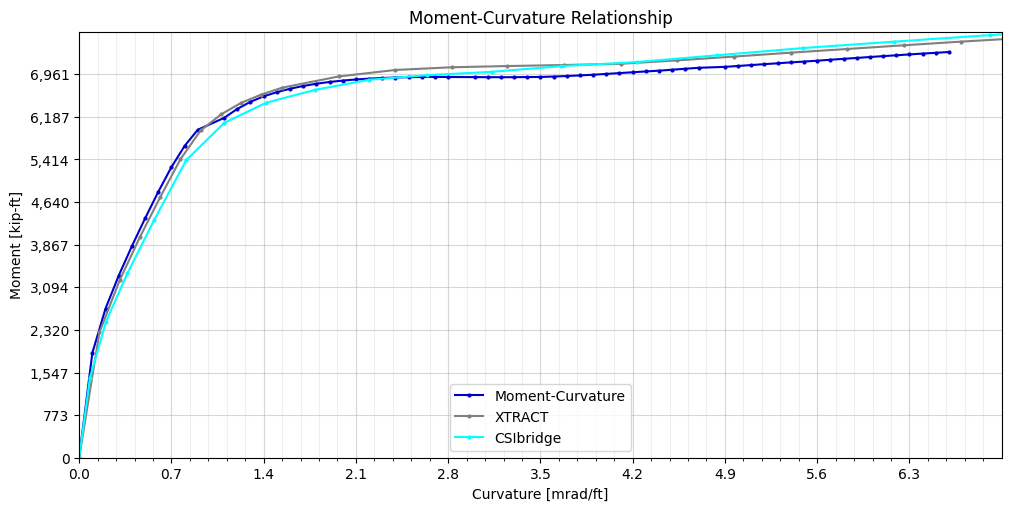

In [13]:
lab_x = 'Curvature [mrad/ft]'
lab_y = 'Moment [kip-ft]'
plot_title = 'Moment-Curvature Relationship'
EngPlots_MCcomp.execute(Kmax, Mmax, np.round(K*1000*12,1), moment, lab_x, lab_y, plot_title, 
            K_xtract, M_xtract, K_csibridge, M_csibridge)

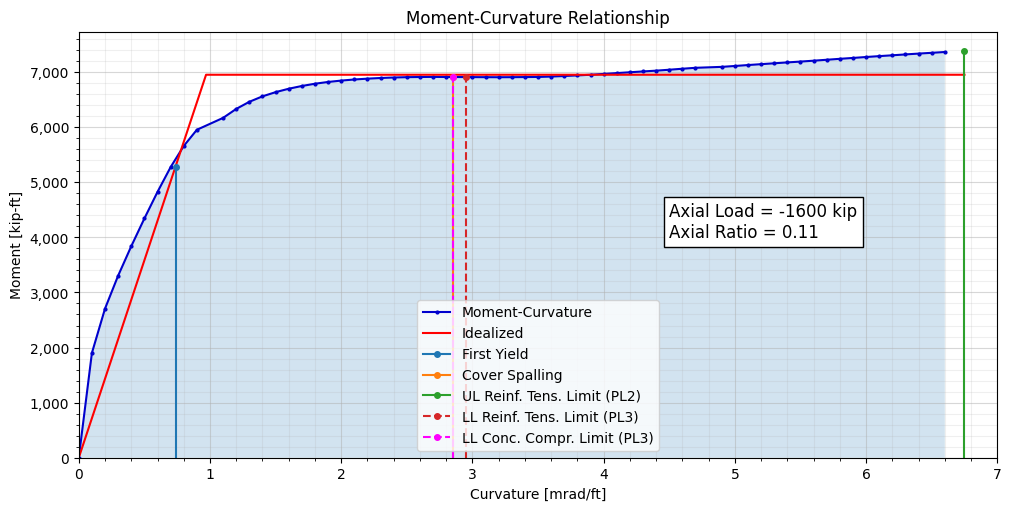

In [14]:
lab_x = 'Curvature [mrad/ft]'
lab_y = 'Moment [kip-ft]'
plot_title = 'Moment-Curvature Relationship'
EngPlots_MC.execute(Kmax, Mmax, np.round(K*1000*12,1), moment, lab_x, lab_y, plot_title, 
                    K1y, Ksp, Kcu_UL, K_Rebc_UL, K_Rebt_UL, Kcu_LL, K_Rebt_LL,
                    M1y, Msp, Mcu_UL, M_Rebc_UL, M_Rebt_UL, Mcu_LL, M_Rebt_LL,
                    Ky, Ku, Mp, axialLoad, r_axial)

In [15]:
print("A_above = ", A_above)
print("A_below = ", A_below)
print("Area Ratio = ", ra)
print("Mp = ", Mp)
print("Ky = ", Ky)
print("Ku = ", Ku)

A_above =  0.0473
A_below =  0.0517
Area Ratio =  0.91
Mp =  6952.0
Ky =  0.97
Ku =  6.75


### Concrete Stress - Strain Relationship

<Figure size 1000x500 with 0 Axes>

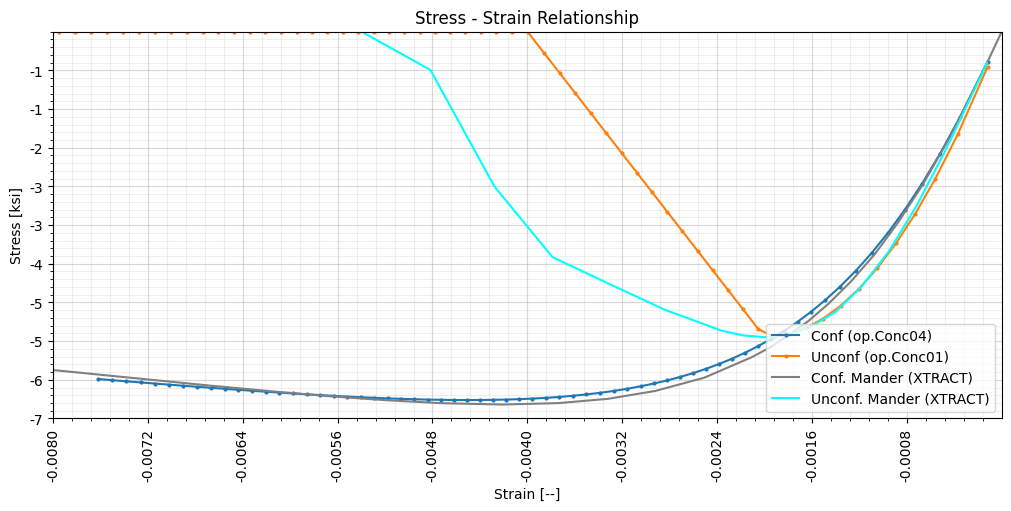

In [16]:
# ------------------------------------------
# Plot Concrete Stress-Strain relationships
# ------------------------------------------

df6 = pd.read_csv('ConfConc_xtract.csv')
ConfStrain_xtract = df6['strain'].values
ConfStress_xtract = df6['stress'].values

df7 = pd.read_csv('UncfConc_xtract.csv')
UncfStrain_xtract = df7['strain'].values
UncfStress_xtract = df7['stress'].values

plt.figure()

ec_min = min(1.05*StrainConfc)
fc_min = min(1.05*StressConfc)
ec_max = 0
fc_max = 0
lab_x = 'Strain [--]'
lab_y = 'Stress [ksi]'
plot_title = 'Stress - Strain Relationship'
Legend = ["Conf (op.Conc04)", "Unconf (op.Conc01)", "Conf. Mander (XTRACT)", "Unconf. Mander (XTRACT)"]
EngPlots_StressStrain.execute(Legend, ec_min, fc_min, ec_max, fc_max, StrainConfc, StressConfc,
                             StrainUncfc, StressUncfc, lab_x, lab_y, plot_title,
                             ConfStrain_xtract, ConfStress_xtract,
                             UncfStrain_xtract, UncfStress_xtract)


### Reinforcement Stress - Strain Relationship

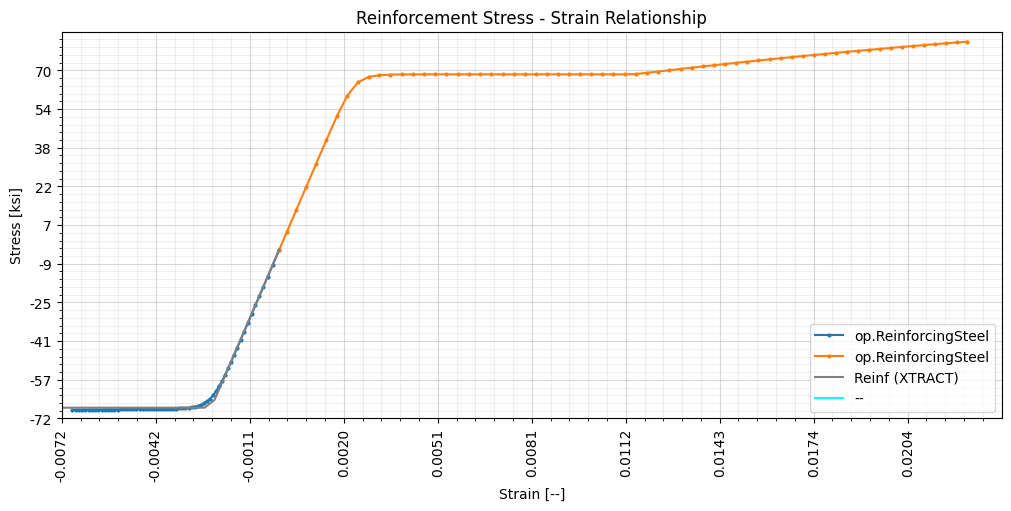

In [17]:
# -----------------------------------------------
# Plot Reinforcement Stress-Strain relationships
# -----------------------------------------------

df8 = pd.read_csv('Reinf_xtract.csv')
RebStrain_xtract = df8['strain'].values
RebStress_xtract = df8['stress'].values

es_min = min(1.05*StrainRebc)
fs_min = min(1.05*StressRebc)
es_max = max(1.05*StrainRebt)
fs_max = max(1.05*StressRebt)
lab_x = 'Strain [--]'
lab_y = 'Stress [ksi]'
plot_title = 'Reinforcement Stress - Strain Relationship'
Legend = ["op.ReinforcingSteel", "op.ReinforcingSteel", "Reinf (XTRACT)", "--"]
EngPlots_StressStrain.execute(Legend, es_min, fs_min, es_max, fs_max, StrainRebc, StressRebc,
                              StrainRebt, StressRebt, lab_x, lab_y, plot_title,
                             RebStrain_xtract, RebStress_xtract, 0, 0)


### Strain Cross section Profile

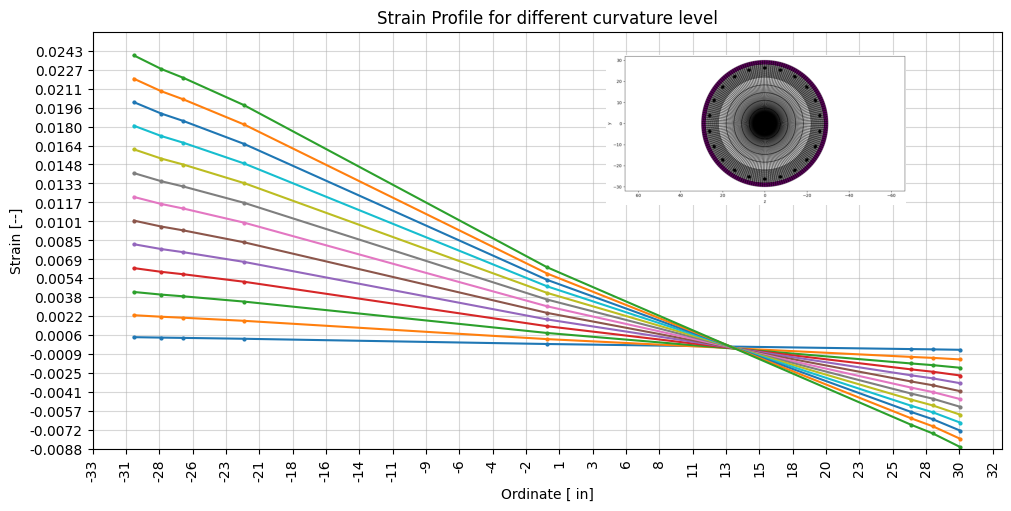

In [18]:

EngPlots_StrainProfile.execute(n_u, r_col, r_core, r_reinf, r_core_int, D_col, es_max, ec_min, 
            StrainUncft, StrainConft, StrainRebt, Strain_int, Straincc,
            StrainRebc, StrainConfc, StrainUncfc)


In [19]:
# section output: using fiberdata option:
# https://portwooddigital.com/2022/05/15/plane-sections-do-remain-plane/
data = eleResponse(eleTag,'section',secTag,'fiberData')

# Python indices indicate to grab every fifth list entry: y, z, A, stress, strain
y = data[0:Ndata:5]
z = data[1:Ndata:5]
h = data[4:Ndata:5]

Matrix = {'z (in)': np.round(z,2),
          'y (in)': np.round(y, 2),
          'Strain (--)': h}

df11 = pd.DataFrame(Matrix, columns = ['z (in)', 'y (in)', 'Strain (--)'] )
pd.set_option('display.max_rows', None)     # Set to None to display all rows
pd.set_option('display.max_columns', None)  # Set to None to display all columns

display(df11)


,z (in),y (in),Strain (--)
0,0.50,28.16,-0.008100
1,1.51,28.13,-0.008079
2,2.51,28.05,-0.008038
3,3.51,27.95,-0.007977
4,4.51,27.80,-0.007895
5,5.49,27.62,-0.007793
6,6.48,27.41,-0.007671
7,7.45,27.16,-0.007529
8,8.42,26.88,-0.007367
9,9.37,26.56,-0.007185


### Stiffness versus Curvature Plot

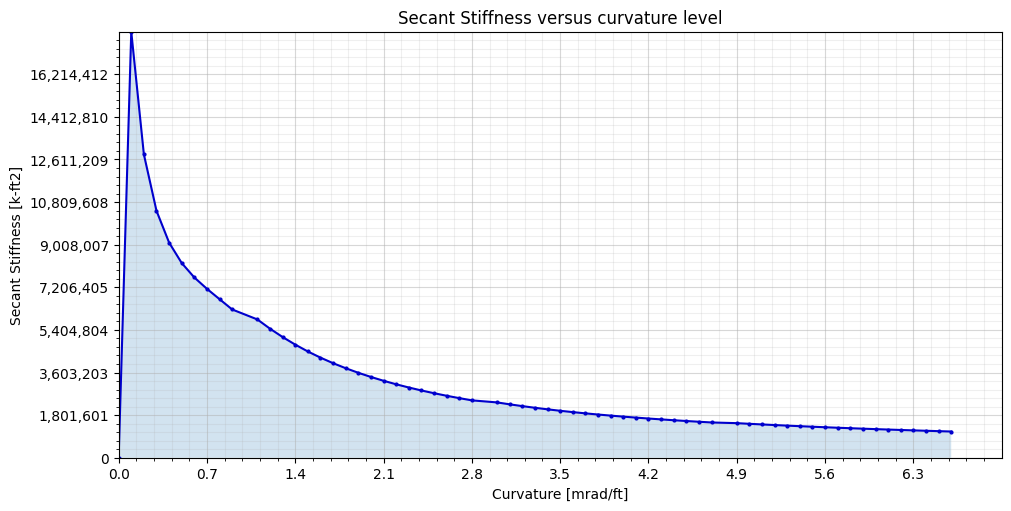

In [20]:
plt.figure()

# Major ticks every 20, minor ticks every 5
major_xticks = np.arange(0, Kmax, Kmax/10)
minor_xticks = np.arange(0, Kmax, Kmax/50)
major_yticks = np.arange(0, max(abs(EIsecant)), max(abs(EIsecant))/10)
minor_yticks = np.arange(0, max(abs(EIsecant)), max(abs(EIsecant))/50)    

ax = plt.axes()
ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor=True)
ax.set_yticks(major_yticks)
ax.set_yticks(minor_yticks, minor=True)

ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
ax.fill_between(np.round(K * 1000 * 12,1), EIsecant, alpha = 0.2)

plt.xlim(0, Kmax)
plt.ylim(0, max(abs(EIsecant)))
plt.plot(np.round(K * 1000 * 12,1), EIsecant, color = 'mediumblue', marker = 'o', markersize=2)

plt.xlabel("Curvature [mrad/ft]")
plt.ylabel("Secant Stiffness [k-ft2]")
plt.title("Secant Stiffness versus curvature level")
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.show()


### Report Summary
P = {eval}`axialLoad` Kip

In [21]:
EngReports.execute(esp, ecu_UL, esc_UL, est_UL, ecu_LL, est_LL, K1y, Ky, Ksp, 
            Ku, EI_1y, M1y, Mp, Mu, Kcu_UL, K_Rebc_UL, K_Rebt_UL, Kcu_LL, K_Rebt_LL)


,0
"Concrete Spalling Strain, esp [--]",-0.0040
"Concrete Ultimate Strain, ecu_UL [--]",-0.0152
"Reinf. buckling Strain, esc_UL [--]",-0.0286
"Reinf. tensile limit Strain, est_UL [--]",0.0229
"LL Unconf. Conc. Comp. Strain Limit, ecu_LL [--]",-0.0040
"LL Reinf. tensile limit Strain Limit, est_LL [--]",0.0100
"Curvature at First Yield, K1y [--]",0.74
"Effective Yield Curvature, Ky [mrad/ft]",0.97
"Curvature at Cover Spalling, Ksp [--]",2.85
"Ultimate Curvature, Ku [mrad/ft]",6.75


### Detailed Report

In [22]:
EngDetailedReports.execute(K, moment, EIsecant, c, StrainConfc, StrainConft, 
                           StrainUncfc, StrainUncft, StrainRebc, StrainRebt, 
                           StressConfc, StressConft, StressUncfc, StressUncft, 
                           StressRebc, StressRebt)


,Curvature [mrad/ft],Moment [k-ft],EIsec [k-ft2],c [in],εConfc [--],εConft [--],εUncfc [--],εUncft [--],εRebc [--],εRebt [--],σConfc [ksi],σConft [ksi],σUncfc [ksi],σUncft [ksi],σRebc [ksi],σRebt [ksi]
0,0.00,0.0,0,0.00,-0.00012,-0.00012,-0.00012,-0.00012,-0.00012,-0.00012,-0.5,-0.5,-0.6,-0.6,-3.5,-3.5
1,0.11,1901.0,"18,016,013",41.88,-0.00035,0.00014,-0.00037,0.00016,-0.00034,0.00013,-1.4,0.0,-1.7,0.0,-9.9,3.7
2,0.21,2707.0,"12,827,288",31.84,-0.00052,0.00045,-0.00056,0.00049,-0.00050,0.00043,-2.1,0.0,-2.5,0.0,-14.6,12.5
3,0.32,3305.0,"10,440,632",27.68,-0.00068,0.00079,-0.00073,0.00084,-0.00064,0.00075,-2.6,0.0,-3.1,0.0,-18.6,21.9
4,0.42,3839.0,"9,095,670",25.35,-0.00082,0.00113,-0.00089,0.00121,-0.00077,0.00109,-3.0,0.0,-3.6,0.0,-22.5,31.6
5,0.53,4343.0,"8,231,830",23.86,-0.00096,0.00148,-0.00105,0.00157,-0.00090,0.00142,-3.4,0.0,-4.0,0.0,-26.2,41.3
6,0.63,4825.0,"7,621,187",22.84,-0.00110,0.00183,-0.00120,0.00194,-0.00103,0.00176,-3.8,0.0,-4.4,0.0,-29.9,50.9
7,0.74,5275.0,"7,141,690",22.08,-0.00123,0.00218,-0.00136,0.00231,-0.00115,0.00210,-4.1,0.0,-4.7,0.0,-33.5,59.3
8,0.84,5659.0,"6,703,881",21.46,-0.00136,0.00254,-0.00151,0.00269,-0.00127,0.00245,-4.3,0.0,-4.9,0.0,-37.0,64.7
9,0.95,5953.0,"6,268,591",20.90,-0.00149,0.00290,-0.00165,0.00307,-0.00138,0.00280,-4.6,0.0,-5.0,0.0,-40.3,66.9


In [23]:
wipe()